In [1]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random

import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

Carregar o modelo

In [2]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

[12/10 20:46:43 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


Carregar dataset de car-damage

In [2]:
from detectron2.data.datasets import register_coco_instances
from detectron2.data import MetadataCatalog, DatasetCatalog

!curl -L "https://universe.roboflow.com/ds/R0WssxzPHH?key=DrYHDd0r3w" > roboflow.zip; unzip roboflow.zip -d datasets/severity; rm roboflow.zip


register_coco_instances("severity-train", {}, "datasets/severity/train/_annotations.coco.json", "datasets/severity/train")
register_coco_instances("severity-test", {}, "datasets/severity/test/_annotations.coco.json", "datasets/severity/test")
register_coco_instances("severity-val", {}, "datasets/severity/valid/_annotations.coco.json", "datasets/severity/valid")

# Verify if the dataset is correctly registered
my_dataset_metadata = MetadataCatalog.get("severity-train")
dataset_dicts = DatasetCatalog.get("severity-train")

print(len(my_dataset_metadata.thing_classes))


WARNING [12/11 20:25:03 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/11 20:25:03 d2.data.datasets.coco]: Loaded 1716 images in COCO format from datasets/damage-type/train/_annotations.coco.json
5


Printar dataset

In [ ]:
''
from detectron2.utils.visualizer import ColorMode

import random
import cv2
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog


for d in random.sample(dataset_dicts, 3):
    im = cv2.imread(d["file_name"])
    visualizer = Visualizer(im[:, :, ::-1], metadata=MetadataCatalog.get("severity-train"), scale=0.8)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()


In [4]:

def custom_mapper(dataset_dict):
    # Load the image from the dataset dictionary
    dataset_dict = copy.deepcopy(dataset_dict)  # Make a copy of the data
    image = cv2.imread(dataset_dict["file_name"])
    
    # Define augmentations
    aug = T.AugmentationList([
        T.ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333),
        T.RandomFlip(prob=0.5, horizontal=True, vertical=False),
        T.RandomBrightness(0.9, 1.1),
        T.RandomContrast(0.9, 1.1),
        T.RandomSaturation(0.9, 1.1)
    ])
    
    # Apply augmentations to the image
    image, transforms = T.apply_augmentations(aug, image)
    
    # Update the dataset dictionary with transformed image
    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))
    
    # Apply transformations to the annotations (bounding boxes, masks, etc.)
    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
    ]
    dataset_dict["annotations"] = annos
    
    return dataset_dict

# Selecionar modelo e treinar dataset de treino

In [44]:
from detectron2.engine import DefaultTrainer
from detectron2.data import build_detection_train_loader

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")) #
cfg.DATASETS.TRAIN = ("severity-train",)
cfg.DATASETS.TEST = ("severity-test",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 40000
cfg.SOLVER.STEPS = (10000, 20000)
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(my_dataset_metadata.thing_classes)

# Use custom mapper with the registered COCO dataset
train_loader = build_detection_train_loader(
    cfg,
    mapper=custom_mapper
)


WARNING [12/10 22:09:08 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/10 22:09:08 d2.data.datasets.coco]: Loaded 3640 images in COCO format from datasets/severity/train/_annotations.coco.json
[12/10 22:09:08 d2.data.build]: Removed 92 images with no usable annotations. 3548 images left.
[12/10 22:09:08 d2.data.build]: Using training sampler TrainingSampler
[12/10 22:09:08 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[12/10 22:09:08 d2.data.common]: Serializing 3548 elements to byte tensors and concatenating them all ...
[12/10 22:09:08 d2.data.common]: Serialized dataset takes 4.14 MiB
[12/10 22:09:08 d2.data.build]: Making batched data loader with batch_size=2


# treinar

In [45]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[12/10 22:09:11 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (10, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (10,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (36, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (36,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (9, 256, 1, 1

[12/10 22:09:11 d2.engine.train_loop]: Starting training from iteration 0
[12/10 22:09:12 d2.utils.events]:  eta: 0:31:32  iter: 19  total_loss: 3.46  loss_cls: 2.217  loss_box_reg: 0.07065  loss_mask: 0.6937  loss_rpn_cls: 0.4419  loss_rpn_loc: 0.04155    time: 0.0472  last_time: 0.0490  data_time: 0.0097  last_data_time: 0.0020   lr: 4.9953e-06  max_mem: 9340M
[12/10 22:09:13 d2.utils.events]:  eta: 0:31:23  iter: 39  total_loss: 3.258  loss_cls: 2.037  loss_box_reg: 0.04429  loss_mask: 0.693  loss_rpn_cls: 0.3384  loss_rpn_loc: 0.03972    time: 0.0471  last_time: 0.0473  data_time: 0.0019  last_data_time: 0.0019   lr: 9.9902e-06  max_mem: 9340M
[12/10 22:09:14 d2.utils.events]:  eta: 0:31:23  iter: 59  total_loss: 3.217  loss_cls: 1.664  loss_box_reg: 0.07186  loss_mask: 0.6917  loss_rpn_cls: 0.7869  loss_rpn_loc: 0.08692    time: 0.0470  last_time: 0.0492  data_time: 0.0019  last_data_time: 0.0019   lr: 1.4985e-05  max_mem: 9340M
[12/10 22:09:15 d2.utils.events]:  eta: 0:31:00  ite

In [25]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

Evaluate

In [10]:
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
import os
from detectron2.data import build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

# Create the COCO evaluator
evaluator = COCOEvaluator("type-test", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "type-test")

metrics = inference_on_dataset(trainer.model, val_loader, evaluator)
print(metrics)
# To inspect precision/recall:
print("AP: ", metrics['bbox']['AP'])  # Average Precision

cfg = get_cfg()
# Configurações para o modelo treinado
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # Caminho para o modelo salvo
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3  # Ajuste o threshold de detecção, se necessário
cfg.DATASETS.TEST = ("type-test", )
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 9  # Adjust based on your dataset
predictor = DefaultPredictor(cfg)


[12/11 20:20:02 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [12/11 20:20:02 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [12/11 20:20:02 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/11 20:20:02 d2.data.datasets.coco]: Loaded 242 images in COCO format from datasets/damage-type/test/_annotations.coco.json
[12/11 20:20:02 d2.data.build]: Distribution of instances among all 5 categories:
|   category    | #instances   |  category  | #instances   |  category   | #instances   |
|:-------------:|:-------------|:----------:|:-------------|:-----------:|:-------------|
| dent-scratc.. | 0            |    dent    | 76           | glass_break | 77           |
|    scratch    | 166          |   smash    | 91           |             |              |
|     tota

/home/ricardofachini/miniconda3/envs/visao-computacional/lib/python3.9/site-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return to

Visualizar resultado

WARNING [12/10 22:56:31 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/10 22:56:31 d2.data.datasets.coco]: Loaded 634 images in COCO format from datasets/severity/test/_annotations.coco.json
tensor([], device='cuda:0', dtype=torch.int64)
Boxes(tensor([], device='cuda:0', size=(0, 4)))


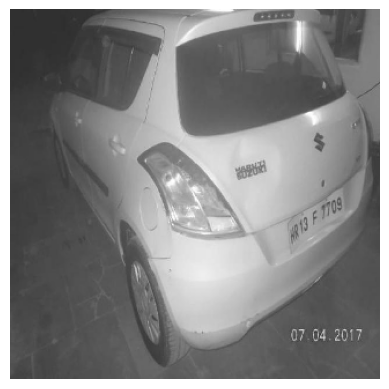

tensor([], device='cuda:0', dtype=torch.int64)
Boxes(tensor([], device='cuda:0', size=(0, 4)))


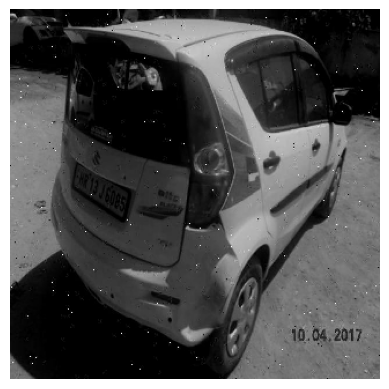

tensor([], device='cuda:0', dtype=torch.int64)
Boxes(tensor([], device='cuda:0', size=(0, 4)))


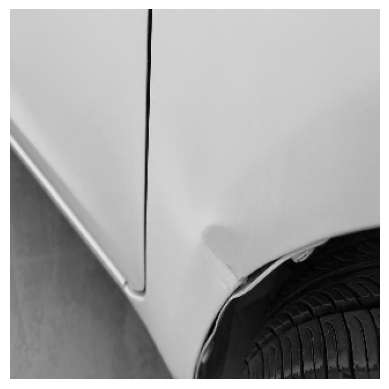

In [55]:
from detectron2.utils.visualizer import ColorMode
import random


dataset_dicts_valid = DatasetCatalog.get("severity-val")
for d in random.sample(dataset_dicts_valid, 3):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=my_dataset_metadata,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    print(outputs["instances"].pred_classes)  # Classes preditas
    print(outputs["instances"].pred_boxes)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.axis('off')
    plt.show()
